In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
plt.style.use("fivethirtyeight")

In [2]:
from sklearn.metrics import roc_auc_score

In [3]:
training_table = pd.read_csv("./data/occupancy_data/datatraining.txt")

In [4]:
# training_table["year"] = training_table["date"].str[:4].astype(int) # only 2015
# training_table["month"] = training_table["date"].str[5:7].astype(int) # only February
training_table["day"] = training_table["date"].str[8:10].astype(int)
training_table["hour"] = training_table["date"].str[11:13].astype(int)

In [5]:
training_table = training_table.drop("date", axis=1)

In [6]:
training_table.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
1,23.18,27.2720,426.0,721.25,0.004793,1,4,17
2,23.15,27.2675,429.5,714.00,0.004783,1,4,17
3,23.15,27.2450,426.0,713.50,0.004779,1,4,17
4,23.15,27.2000,426.0,708.25,0.004772,1,4,17
5,23.10,27.2000,426.0,704.50,0.004757,1,4,17


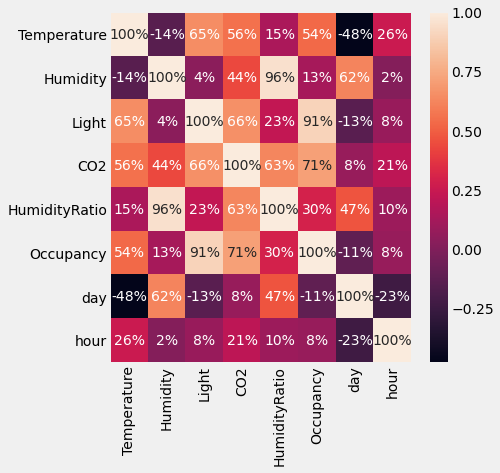

In [7]:
plt.figure(figsize=(6, 6))
sns.heatmap(training_table.corr(), annot=True, fmt=".0%")

In [8]:
SEQ_LEN = 50
NUM_FEAT = 7
DROP = 0.5

In [9]:
X_train = training_table.drop("Occupancy", axis=1).values
Y_train = training_table["Occupancy"].values
training_sequence = [(X_train[i:i+SEQ_LEN, :], Y_train[i+SEQ_LEN]) for i in range(0, len(X_train) - SEQ_LEN)]
N = len(Y_train)

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from rnn import StochasticLSTM
from utils import weight_coefficient, bias_coefficient, filter_parameters, train_model

In [11]:
dataloader = torch.utils.data.DataLoader(training_sequence, batch_size=200, shuffle=True, num_workers=2)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = StochasticLSTM(NUM_FEAT, 50, dropout_rate=DROP)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1,:]
        result = torch.relu(self.fc1(result))
        result = torch.sigmoid(self.fc2(result))
        return result

In [13]:
net = Net().double()
criterion = nn.BCELoss()

M = filter_parameters(net.named_parameters(), "rnn", "weight")
m = filter_parameters(net.named_parameters(), "rnn", "bias")
other_params = filter_parameters(net.named_parameters(), "fc", "")

parameters = [
    {"params": M, "weight_decay": weight_coefficient(1, 1, DROP, N)}, # dropout rnn weight
    {"params": m, "weight_decay": bias_coefficient(1, 1, N)}, # dropout rnn bias
    {"params": other_params} # other parameters
]
optimizer = optim.Adam(parameters, lr=0.001)

In [14]:
train_model(net, dataloader, criterion, optimizer, 10)

[1,    40] loss: 0.577307
[2,    40] loss: 0.484936
[3,    40] loss: 0.362168
[4,    40] loss: 0.389938
[5,    40] loss: 0.333630
[6,    40] loss: 0.360247
[7,    40] loss: 0.494047
[8,    40] loss: 0.393488
[9,    40] loss: 0.462336
[10,    40] loss: 0.357515
Finish training


## Test

In [15]:
testing_table = pd.read_csv("./data/occupancy_data/datatest2.txt")
testing_table["day"] = testing_table["date"].str[8:10].astype(int)
testing_table["hour"] = testing_table["date"].str[11:13].astype(int)
testing_table = testing_table.drop("date", axis=1)

In [16]:
X_test = testing_table.drop("Occupancy", axis=1).values
X_test = np.array([X_test[i:i+SEQ_LEN, :] for i in range(0, len(X_test) - SEQ_LEN)])
X_test = X_test.swapaxes(1, 0)
Y_test = testing_table["Occupancy"].values[SEQ_LEN:]

In [17]:
X_test = torch.tensor(X_test)

In [18]:
with torch.no_grad():
    outputs = net(X_test).flatten().data.numpy()

In [19]:
roc_auc_score(Y_test, outputs)

0.9898579991437133